### 0. Observacion de los datos del CSV

Inicialmente, se observa una mezcla de data types. Caracteres, decimales, negativos... La lectura del metodo ` read_csv` no parece correcta, ya que malinterpreta algunos decimales por strings, ya que no interpreta la coma como un indicativo de decimal, si no como un signo de una cadena de texto. Cambiando las comas decimales por puntos, hara que esto funcione adecuadamente. 

In [40]:
import pandas as pd
import numpy as np 

df_og = pd.read_csv('../data/raw/dataset.csv', sep=';', low_memory=False)

In [41]:
df_og.info()
df = df_og.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

### 1. Observación de nulos

Los datatypes parecen adecuados acorde a las descripciones de las columnas que tenemos. Aquellos definidos como `object` se refieren a cadenas de texto o caracteres. Varias columnas tienen datos nulos, asi que hay que observar como gestionar estos casos.

In [42]:
def calcular_nulos(df):
    """
    Calcula el número de valores nulos y su porcentaje en cada columna del DataFrame.
    """
    null_counts = df.isnull().sum()
    null_percentages = (df.isnull().sum() / len(df)) * 100

    null_info = pd.DataFrame({
        'Nulos': null_counts,
        'Porcentaje': null_percentages
    })

    return null_info

null_info = calcular_nulos(df)
print(null_info)

             Nulos  Porcentaje
rev_Mean       357       0.357
mou_Mean       357       0.357
totmrc_Mean    357       0.357
da_Mean        357       0.357
ovrmou_Mean    357       0.357
...            ...         ...
kid11_15      1732       1.732
kid16_17      1732       1.732
creditcd      1732       1.732
eqpdays          1       0.001
Customer_ID      0       0.000

[100 rows x 2 columns]


<Figure size 2580x2580 with 0 Axes>

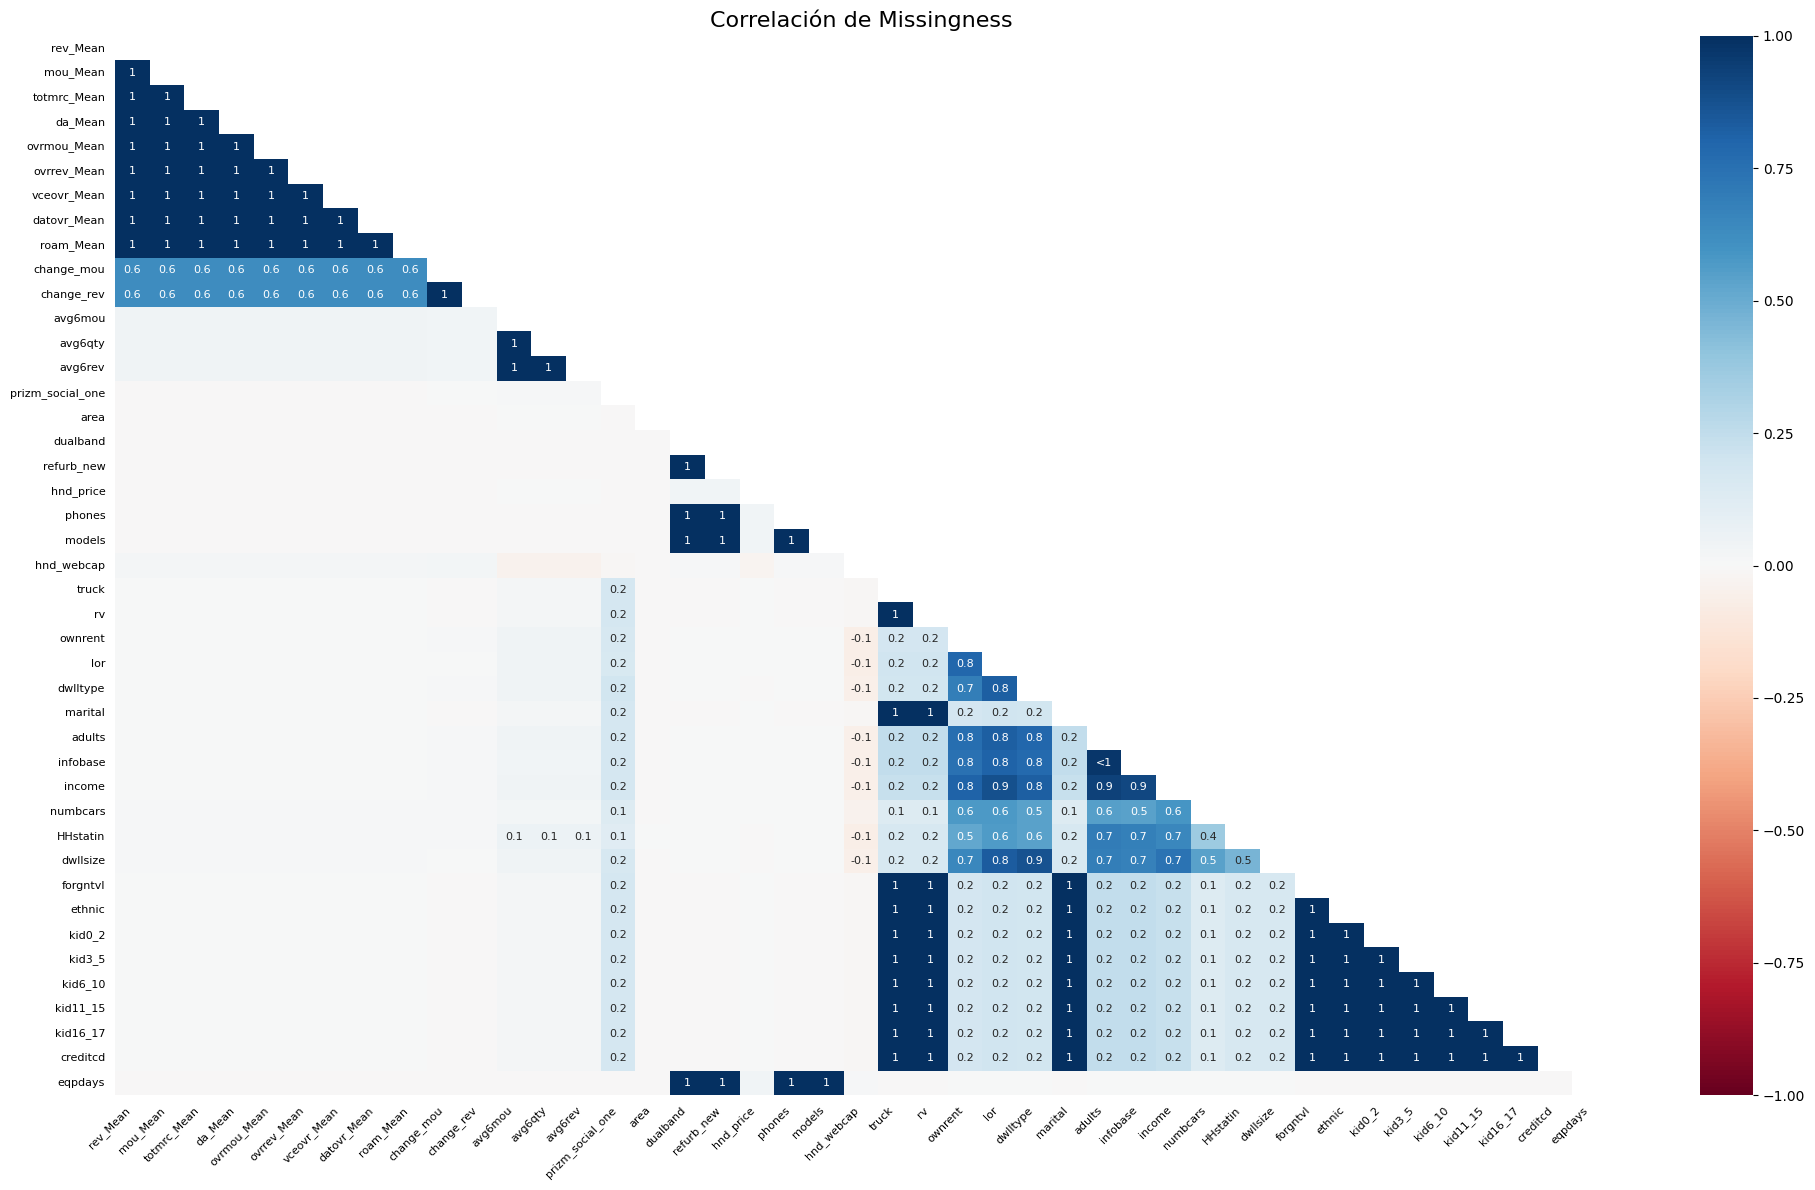

In [43]:
import missingno as msno
import matplotlib.pyplot as plt

columns_with_nans = null_info[null_info['Nulos'] > 0].index.tolist()

null_flags_df_subset = df[columns_with_nans].isnull()

missing_patterns_subset = null_flags_df_subset.groupby(null_flags_df_subset.columns.tolist()).size().reset_index(name='count')

print("\n")
    
num_cols = len(columns_with_nans)
recommended_width = max(10, num_cols * 0.6)
recommended_height = max(9, num_cols * 0.6) 

plt.figure(figsize=(recommended_width, recommended_height))
ax = msno.heatmap(df[columns_with_nans], fontsize=10) 

plt.xticks(rotation=45, ha='right', fontsize=8) 
plt.yticks(rotation=0, fontsize=8) 

plt.title('Correlación de Missingness', fontsize=16)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()
    

En la matriz podemos ver que claramente hay correlación en los nulos de diferentes variables. Hay cinco agrupaciones claras. 

1. La más superior, referente a las variables `avg6rev/qty/mou` con 2839 nulos.
2. Siguiendo por aques variables `kid`, `marital`, `forgntvl`, `creditcd`, `truck`, `rv` and `ethnic`, con 1732 nulos.
3. `change_mou` y `change_rev` también coinciden en nulos, con 891.
4. El siguiente gran grupo de correlaciones de nulos es de aquellos que acaban en `_Mean`, referentes a servicios extra que se dan (voiceover, data overage, roaming...) con 357 nulos.
5. Y el último grupo incluye `refurb_new`, `models`, `phones`, `dualband` y `eqpdays`, que sólo pertenecen a una única fila.

### Caso 1. Columnas avg6*

Inicialmente podríamos pensar que son nulas debido a que esta variable se refiere a una media de un periodo de 6 meses. Tenemos que verificar cuánto tiempo llevan estos registros, utilizando la variable `months` para ver si podemos considerarlo o no y cómo debemos tratarlo.

In [44]:
# Verifica si hay registros con meses mayores a 6
len(df['months']> 6)


100000

Todos los valores llevan más de 6 meses en el servicio, por lo tanto, la falta de ese dato no se debe a esta razón. Imputar con 0 a estos valores sería incorrecto, porque no sabemos si el origen de esta falta de dato se debe a un cambio de facturación, a una falta de uso, a un error... Además, como es una parte importante de los datos, un 28.39%, es necesario tratarlo de alguna manera.

1. Crearemos una columna de flag, `avg6_nan`, que esté a 1 si el valor no estaba, y a 0 si estaba rellenado.
2. Observamos la distribución de los valores no nulos, para decidir si imputamos por mediana o por media.

In [45]:
# Como parece que vamos a usar esto más de una vez, vamos a hacer una función para crear la columna de flag

def crear_flag_nulos(df: pd.DataFrame, columna_a_verificar: str, nueva_columna_flag: str) -> pd.DataFrame:
    """
    Crea una columna binaria (flag) en un DataFrame que indica la presencia de valores nulos
    en una columna específica.

    Args:
        df (pd.DataFrame): El DataFrame de entrada.
        columna_a_verificar (str): El nombre de la columna donde se buscarán los valores nulos.
        nueva_columna_flag (str): El nombre de la nueva columna que contendrá el flag (1 si es nulo, 0 si no lo es).

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna flag añadida.
    """
    if columna_a_verificar not in df.columns:
        raise ValueError(f"La columna '{columna_a_verificar}' no se encuentra en el DataFrame.")

    boolean_mask = df[columna_a_verificar].isnull()
    df[nueva_columna_flag] = np.where(boolean_mask, 1, 0)

    print(f"Número de 1s en la nueva columna flag: {df[df[columna_a_verificar].isnull()][nueva_columna_flag].value_counts()}\n")
    
    return df

In [46]:
crear_flag_nulos(df, 'avg6rev', 'avg6_nan')

Número de 1s en la nueva columna flag: avg6_nan
1    2839
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,avg6_nan
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,N,U,U,U,U,U,Y,361.0,1000001,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,Z,U,U,U,U,U,Y,240.0,1000002,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,N,U,Y,U,U,U,Y,1504.0,1000003,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,U,Y,U,U,U,U,Y,1812.0,1000004,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,I,U,U,U,U,U,Y,434.0,1000005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,S,U,U,U,Y,U,Y,773.0,1099996,0
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N,U,U,Y,Y,Y,Y,835.0,1099997,0
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,Y,Y,U,U,U,N,433.0,1099998,0
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,S,U,U,U,U,U,N,75.0,1099999,0


In [47]:
import matplotlib.pyplot as plt
import math

# Esto también podría sernos útil para observar las distribuciones de otras variables
def graficar_distribuciones(df: pd.DataFrame, columnas: list, n_cols: int = 3, bins: int = 30):
    """
    Genera y muestra histogramas para una lista de columnas de un DataFrame,
    ignorando los valores nulos.

    La función organiza los gráficos en una cuadrícula cuyo número de columnas se puede definir.

    Args:
        df (pd.DataFrame): El DataFrame que contiene los datos.
        columnas (list): Una lista de strings con los nombres de las columnas a graficar.
        n_cols (int): El número de columnas que tendrá la cuadrícula de gráficos. Por defecto es 3.
        bins (int): El número de contenedores (bins) para cada histograma. Por defecto es 30.
    """
    # Validar que las columnas existan en el DataFrame
    for col in columnas:
        if col not in df.columns:
            print(f"Advertencia: La columna '{col}' no se encuentra en el DataFrame y será ignorada.")
            columnas.remove(col)
            
    if not columnas:
        print("No hay columnas válidas para graficar.")
        return

    # Calcular el número de filas necesarias para la cuadrícula
    n_rows = math.ceil(len(columnas) / n_cols)

    # Crear la figura y los subplots (ejes)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    
    # Aplanar el array de ejes para iterar fácilmente, incluso si es de una sola fila/columna
    axes = axes.flatten()

    # Iterar sobre cada columna y su eje correspondiente para crear el gráfico
    for i, col_nombre in enumerate(columnas):
        # Seleccionar los datos no nulos
        datos_no_nulos = df[col_nombre].dropna()
        
        # Graficar el histograma en el eje correspondiente
        axes[i].hist(datos_no_nulos, bins=bins, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribución de {col_nombre}')
        axes[i].set_xlabel(col_nombre)
        axes[i].set_ylabel('Frecuencia')

        min_val = datos_no_nulos.min()
        max_val = datos_no_nulos.max()
        axes[i].set_xlim(left=min_val, right=max_val)
    # Ocultar los ejes sobrantes si el número de gráficos no completa la cuadrícula
    for i in range(len(columnas), len(axes)):
        axes[i].set_visible(False)

    # Ajustar el diseño para que no se superpongan los títulos y etiquetas
    plt.tight_layout()
    plt.show()

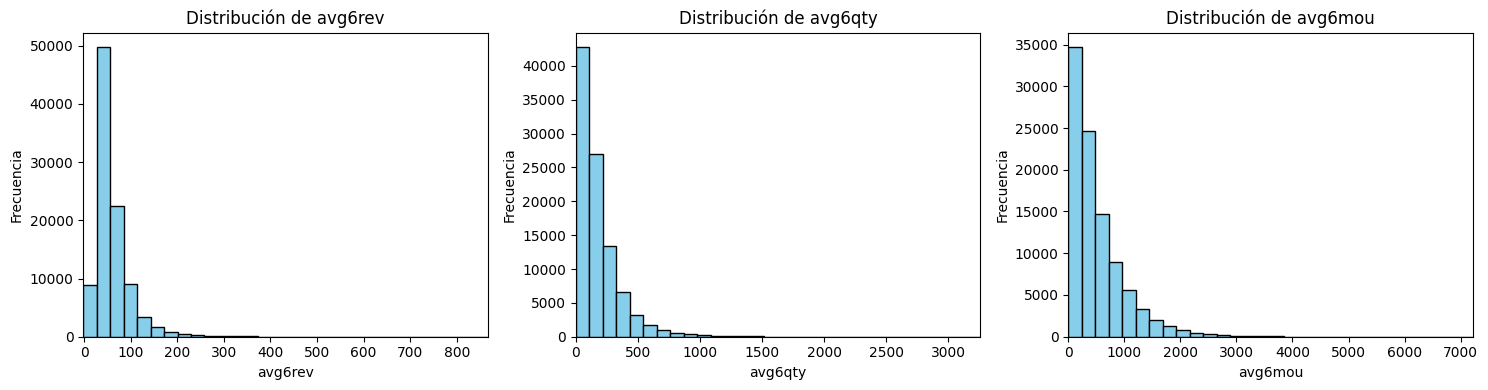

In [48]:
graficar_distribuciones(df, ['avg6rev', 'avg6qty', 'avg6mou'], n_cols=3, bins=30)

Con la observación de cómo se distribuyen los valores de las diferentes variables, podemos ver que el mejor trato es la **mediana**, ya que el mayor peso de los valores en las 3 variables está en la izquierda, y la media se verá más afectada. 

In [49]:
#Otra función que podrías sernos útil

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

def imputar_valores_nulos(df: pd.DataFrame, columnas: list, estrategia: str = 'mediana', valor_relleno: str = 'UNKN') -> pd.DataFrame:
    """
    Imputa valores nulos en columnas de un DataFrame usando una estrategia definida.

    Soporta estrategias numéricas ('media', 'mediana', 'moda') y una estrategia
    para valores constantes ('constante'), útil para variables categóricas.

    Args:
        df (pd.DataFrame): El DataFrame de entrada.
        columnas (list): Lista de nombres de las columnas a imputar.
        estrategia (str): Método de imputación. Acepta 'mediana', 'media', 'moda', o 'constante'.
                          Por defecto es 'mediana'.
        valor_relleno (str): El valor a usar cuando la estrategia es 'constante'.
                             Por defecto es 'UNKN'.

    Returns:
        pd.DataFrame: Un nuevo DataFrame con los valores nulos imputados.
    """
    df_imputado = df.copy()
    
    estrategias_validas = ['mediana', 'media', 'moda', 'constante']
    if estrategia.lower() not in estrategias_validas:
        raise ValueError(f"Estrategia no válida. Elija entre: {estrategias_validas}")

    print(f"--- Iniciando imputación con la estrategia: '{estrategia}' ---")

    for col in columnas:
        if col not in df_imputado.columns:
            print(f"Advertencia: La columna '{col}' no se encuentra en el DataFrame y será ignorada.")
            continue

        if df_imputado[col].isnull().any():
            valor_imputacion = None
            
            # --- Lógica para estrategias numéricas ---
            if estrategia in ['mediana', 'media', 'moda']:
                # Verificar que la columna sea numérica para estas estrategias
                if not is_numeric_dtype(df_imputado[col]):
                    print(f"Advertencia: La columna '{col}' no es numérica. La estrategia '{estrategia}' no se puede aplicar. Se omite la columna.")
                    continue
                
                if estrategia == 'mediana':
                    valor_imputacion = df_imputado[col].median()
                elif estrategia == 'media':
                    valor_imputacion = df_imputado[col].mean()
                elif estrategia == 'moda':
                    valor_imputacion = df_imputado[col].mode()[0]
                
                print(f"-> Columna numérica '{col}' imputada con la {estrategia}: {valor_imputacion:.2f}")

            # --- Lógica para la estrategia de constante (categórica o numérica) ---
            elif estrategia == 'constante':
                valor_imputacion = valor_relleno
                print(f"-> Columna '{col}' imputada con el valor constante: '{valor_imputacion}'")

            # Aplicar la imputación
            df_imputado[col] = df_imputado[col].fillna(valor_imputacion)
            
        else:
            print(f"-> Columna '{col}' no tiene valores nulos. No se requiere imputación.")
            
    return df_imputado



In [50]:
df = imputar_valores_nulos(df, columnas =['avg6rev', 'avg6qty', 'avg6mou'], estrategia='mediana')

--- Iniciando imputación con la estrategia: 'mediana' ---
-> Columna numérica 'avg6rev' imputada con la mediana: 50.00
-> Columna numérica 'avg6qty' imputada con la mediana: 127.00
-> Columna numérica 'avg6mou' imputada con la mediana: 363.00


## Caso 2. Variables categóricas

Hay que distinguir entre aquellas que son categóricas con caracteres, y aquellas que son binarias con 0 y 1, lo cual la lectura del CSV, al tener NaNs, ha interpretado como float. En este caso son `rv`, `truck` y `forgntvl`.

El resto de las variables son todas categóricas, podrían proceder de diferentes fuentes de datos o secciones que no son obligatorias rellenar o que no siempre se encuentran disponibles. 

Para generar la columna extra, podemos considerar una única de las categorías, y después trataremos por separado aquellas interpretadas como `float`, y aquellas como `object`.

In [51]:
crear_flag_nulos(df, 'ethnic', 'categorical_nan')

Número de 1s en la nueva columna flag: categorical_nan
1    1732
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,avg6_nan,categorical_nan
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,U,U,U,U,U,Y,361.0,1000001,0,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,U,U,U,U,U,Y,240.0,1000002,0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,U,Y,U,U,U,Y,1504.0,1000003,0,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,Y,U,U,U,U,Y,1812.0,1000004,0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,U,U,U,U,U,Y,434.0,1000005,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,U,U,Y,U,Y,773.0,1099996,0,0
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,U,Y,Y,Y,Y,835.0,1099997,0,0
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,Y,U,U,U,N,433.0,1099998,0,0
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,U,U,U,U,N,75.0,1099999,0,0


Ahora necesitamos lidiar con aquellas que son categóricas, pero de 0 y 1, ya que tenemos que ver cómo gestionar sus nulos y qué imputarles.

In [52]:
import seaborn as sns

def graficar_distribuciones_categoricas(df: pd.DataFrame, columnas: list, n_cols: int = 3):
    """
    Genera y muestra gráficos de barras para visualizar la distribución de
    variables categóricas en un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame que contiene los datos.
        columnas (list): Una lista de strings con los nombres de las columnas categóricas a graficar.
        n_cols (int): El número de columnas que tendrá la cuadrícula de gráficos. Por defecto es 3.
    """
    # Validar que las columnas existan en el DataFrame
    columnas_validas = [col for col in columnas if col in df.columns]
    if not columnas_validas:
        print("Ninguna de las columnas proporcionadas se encuentra en el DataFrame.")
        return

    # Calcular el número de filas necesarias
    n_rows = math.ceil(len(columnas_validas) / n_cols)

    # Crear la figura y los subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4.5))
    axes = axes.flatten()

    # Iterar sobre cada columna para crear su gráfico de barras
    for i, col_nombre in enumerate(columnas_validas):
        ax = axes[i]
        # Usamos sns.countplot, la herramienta perfecta para esta tarea
        sns.countplot(x=col_nombre, data=df, ax=ax, palette='viridis', hue=col_nombre, legend=False)
        ax.set_title(f'Distribución de {col_nombre}')
        ax.set_xlabel('Categoría')
        ax.set_ylabel('Frecuencia (Conteo)')

        # Opcional: Para mejorar la legibilidad de los ejes con 0 y 1
        # Si la columna es de tipo numérico (int/float) con valores 0 y 1, cambiamos las etiquetas
        if pd.api.types.is_numeric_dtype(df[col_nombre]) and set(df[col_nombre].unique()).issubset({0, 1}):
            ax.set_xticklabels(['No (0)', 'Sí (1)'])
            ax.set_xlabel('Respuesta')

    # Ocultar los ejes sobrantes
    for i in range(len(columnas_validas), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

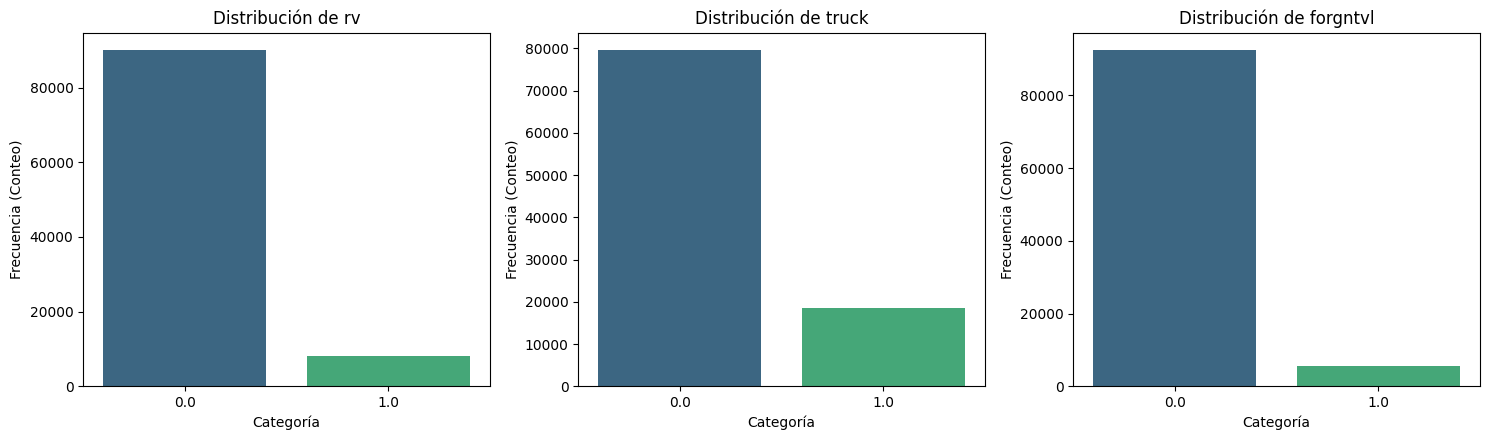

In [53]:
graficar_distribuciones_categoricas(df, ['rv', 'truck', 'forgntvl'], n_cols=3)

Asumimos que 0 significa "No" y 1 significa "Sí". En este caso, como vemos en las 3 categorías hay una clara predominancia del 0, así que podemos asumir que los NaN corresponden a no tener estas variables (básicamente es una sustitución por moda). 

In [54]:
df = imputar_valores_nulos(df, columnas =['rv', 'truck', 'forgntvl'], estrategia='moda')

#Aprovechamos para cambiar su tipo a int, ya que son binarias
#df['rv'] = df['rv'].astype(int)
#df['truck'] = df['truck'].astype(int)
#df['forgntvl'] = df['forgntvl'].astype(int)

--- Iniciando imputación con la estrategia: 'moda' ---
-> Columna numérica 'rv' imputada con la moda: 0.00
-> Columna numérica 'truck' imputada con la moda: 0.00
-> Columna numérica 'forgntvl' imputada con la moda: 0.00


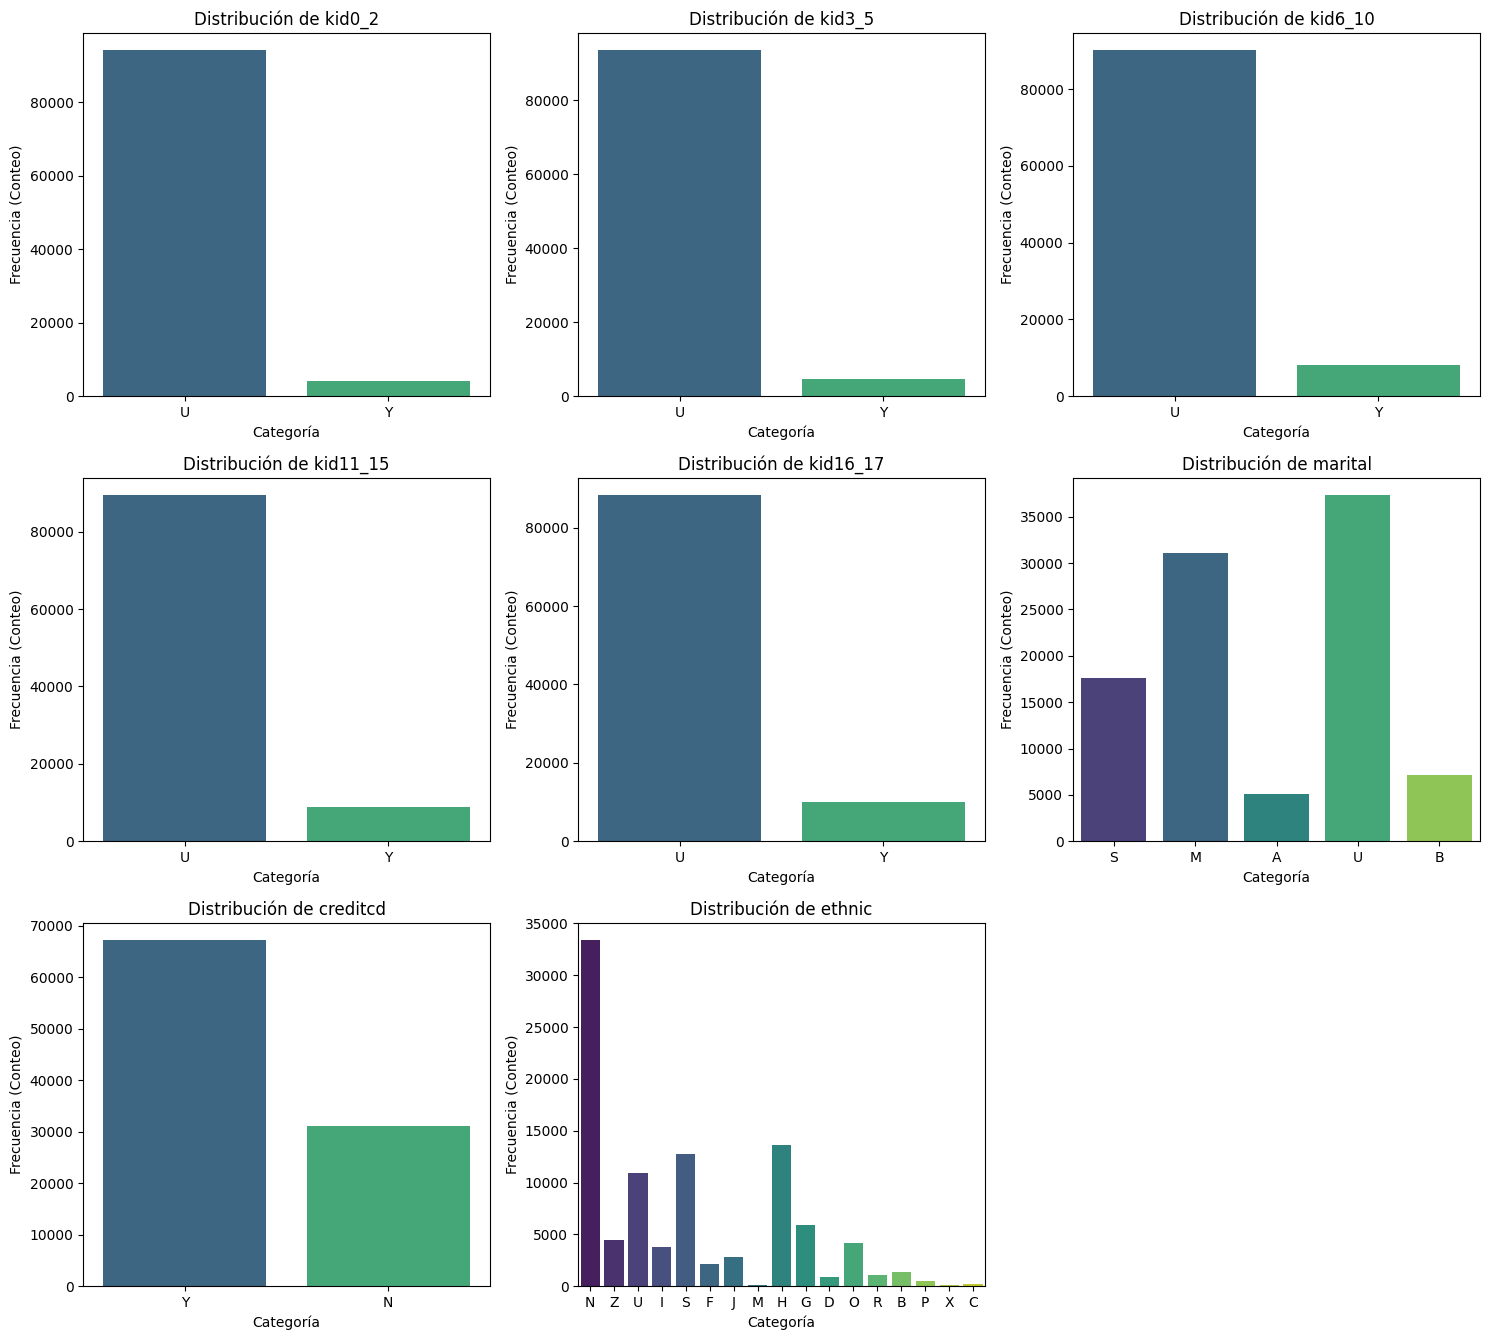

In [55]:
graficar_distribuciones_categoricas(df, ['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'marital', 'creditcd', 'ethnic'], n_cols=3,)

Aquí observamos diferentes patrones de los valores que no son nulos. Las categorías `kid*` tienen un alto número de 'U', que suponemos proviene de aquellos usuarios que no tienen hijos de esa edad, y no rellenan esa información. Por lo tanto, rellenamos los 'U' y los NaN con el valor 0, y el resto con el valor 1.

In [57]:
# Generamos la columna de flag para la variable kids_nan
crear_flag_nulos(df, 'kid0_2', 'kids_nan')

for col in ['kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']:
    # Rellena los nulos con 0 y mapea los valores 'Y' y 'N' a 1 y 0 respectivamente.
    df = imputar_valores_nulos(df, columnas=[col], estrategia='constante', valor_relleno='N')
    #df[col].map({'Y': 1, 'N': 0}).astype(int)
    

Número de 1s en la nueva columna flag: Series([], Name: count, dtype: int64)

--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'kid0_2' no tiene valores nulos. No se requiere imputación.
--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'kid3_5' imputada con el valor constante: 'N'
--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'kid6_10' imputada con el valor constante: 'N'
--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'kid11_15' imputada con el valor constante: 'N'
--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'kid16_17' imputada con el valor constante: 'N'


Desconocemos el significado de algunas variables en `marital`: soltero (s - single), casado (m - married), los grupos A y B desconocemos su origen, y volvemos a tener mucha predominancia de U, que sospechamos que es desconocido (unknown).

Primero, como siempre, crearemos la columna extra `marital_nan`. Después, los grupos A y B se irán a otra categoría, llamada Other (Otros), y los NaN serán asociados a U (Unknown).

In [58]:
crear_flag_nulos(df, 'marital', 'marital_nan')

Número de 1s en la nueva columna flag: marital_nan
1    1732
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,avg6_nan,categorical_nan,kids_nan,marital_nan
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,U,U,U,Y,361.0,1000001,0,0,0,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,U,U,U,Y,240.0,1000002,0,0,0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,U,U,U,Y,1504.0,1000003,0,0,0,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,U,U,U,Y,1812.0,1000004,0,0,0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,U,U,U,Y,434.0,1000005,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,Y,U,Y,773.0,1099996,0,0,0,0
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,Y,Y,Y,835.0,1099997,0,0,0,0
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,U,U,N,433.0,1099998,0,0,0,0
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,U,U,N,75.0,1099999,0,0,0,0


In [59]:
# 1. Agrupar las categorías 'A' y 'B' en la nueva categoría "Otros"
#df['marital'] = df['marital'].replace(['A', 'B'], 'Otros')

# 2. Rellenar los valores nulos (NaN) con la categoría 'U' (desconocido)
df = imputar_valores_nulos(df, columnas=['marital'], estrategia='constante', valor_relleno='U')

# 3. (Recomendado) Verificar el resultado para confirmar que los cambios son correctos
print("Distribución de 'marital' después de la limpieza:")
print(df['marital'].value_counts(dropna=False))

--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'marital' imputada con el valor constante: 'U'
Distribución de 'marital' después de la limpieza:
marital
U    39065
M    31052
S    17627
B     7116
A     5140
Name: count, dtype: int64


Finalmente, únicamente nos queda la categoría `creditcd`, que por suerte tiene únicamente los valores 'Y' (Sí) y 'N' (No). En este caso, aunque la moda es 'Y', hay muchos 'N' presentes, y no podemos asumir que si un usuario no ha especificado tener tarjeta de crédito, eso implique que la tiene. Vamos a reasignar los NaN con 'N'. Como siempre, después de generar la columna flag `creditcd_nan`

In [60]:
crear_flag_nulos(df, 'creditcd', 'creditcd_nan')

df = imputar_valores_nulos(df, columnas =['creditcd'], estrategia='constante', valor_relleno='N')
#df['creditcd'] = df['creditcd'].map({'Y': 1, 'N': 0}).astype(int)

df['creditcd'].isnull().sum()

Número de 1s en la nueva columna flag: creditcd_nan
1    1732
Name: count, dtype: int64

--- Iniciando imputación con la estrategia: 'constante' ---
-> Columna 'creditcd' imputada con el valor constante: 'N'


np.int64(0)

Finalmente, sólo queda la variable `ethnic` que tiene muchísima diversidad de valores, y desconocemos su significado. Por lo tanto, aquí sí nos vamos a detener más en agrupar categorías con pequeña representación, además de su corresopndiente columna de nulos.

In [62]:
crear_flag_nulos(df, 'ethnic', 'ethnic_nan')

Número de 1s en la nueva columna flag: ethnic_nan
1    1732
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid16_17,creditcd,eqpdays,Customer_ID,avg6_nan,categorical_nan,kids_nan,marital_nan,creditcd_nan,ethnic_nan
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,U,1,361.0,1000001,0,0,0,0,0,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,U,1,240.0,1000002,0,0,0,0,0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,U,1,1504.0,1000003,0,0,0,0,0,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,U,1,1812.0,1000004,0,0,0,0,0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,U,1,434.0,1000005,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,1,773.0,1099996,0,0,0,0,0,0
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,1,835.0,1099997,0,0,0,0,0,0
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,0,433.0,1099998,0,0,0,0,0,0
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,0,75.0,1099999,0,0,0,0,0,0


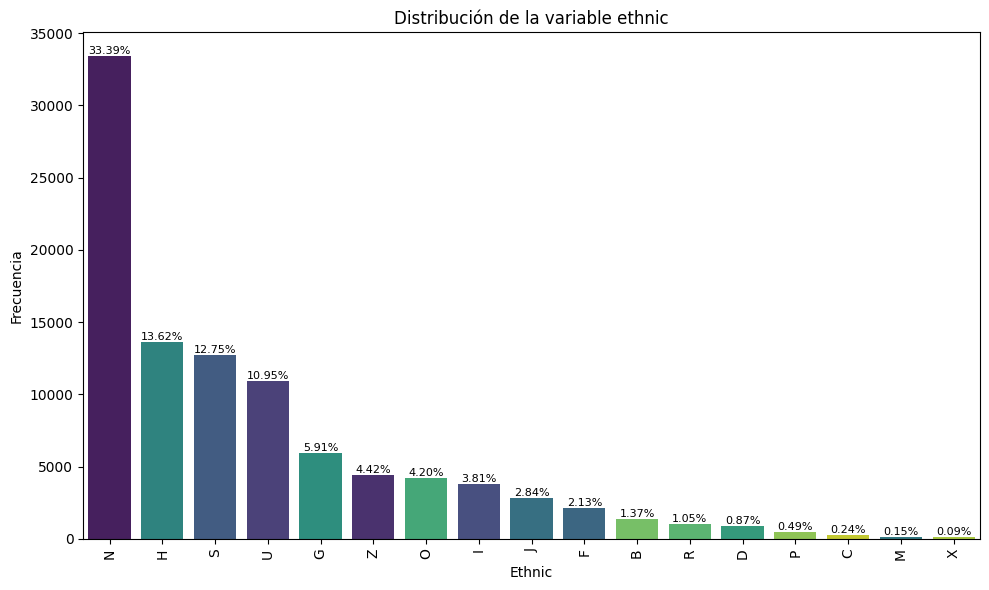

In [65]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='ethnic', data=df, order=df['ethnic'].value_counts().index, palette='viridis', hue='ethnic', legend=False)
plt.xticks(rotation=90)
plt.title('Distribución de la variable ethnic')
plt.xlabel('Ethnic')
plt.ylabel('Frecuencia')
plt.tight_layout()

total = len(df)
for p in ax.patches:
    height = p.get_height()
    proportion = height / total * 100
    ax.annotate(f'{proportion:.2f}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()

Para analizar mejor cómo impacta esta variable en nuestro valor objetivo, `churn`, vamos a analizar el impacto de cada una de estas categorías.

In [72]:
def analizar_churn_categorica(df: pd.DataFrame, columna: str, target: str = 'churn'):
    """
    Versión mejorada que analiza y visualiza la tasa de churn para una variable categórica
    con dos gráficos: distribución y tasa de churn.
    """
    if columna not in df.columns:
        print(f"Error: La columna '{columna}' no se encuentra en el DataFrame.")
        return

    print(f"--- Análisis de Churn para la Variable Categórica: '{columna}' ---")

    tasa_churn_general = df[target].mean()
    analisis = df.groupby(columna)[target].agg(['mean', 'count']).rename(
        columns={'mean': 'Tasa de Churn', 'count': 'Total Clientes'}
    ).sort_values(by='Tasa de Churn', ascending=False)
    
    print(analisis)
    print("\n")

    # --- Creación de la visualización con dos subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Análisis de Churn por "{columna}"', fontsize=18, weight='bold')

    # Gráfico 1: Distribución de Clientes
    sns.barplot(x=analisis.index, y=analisis['Total Clientes'], ax=axes[0], palette='viridis', hue=analisis.index)
    axes[0].set_title('Distribución de Clientes por Categoría', fontsize=14)
    axes[0].set_xlabel(columna, fontsize=12)
    axes[0].set_ylabel('Número de Clientes', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)

    # Gráfico 2: Tasa de Churn
    sns.barplot(x=analisis.index, y=analisis['Tasa de Churn'], ax=axes[1], palette='plasma', hue=analisis.index)
    axes[1].axhline(tasa_churn_general, color='red', linestyle='--', 
                    label=f'Tasa General ({tasa_churn_general:.2%})')
    axes[1].set_title('Tasa de Churn por Categoría', fontsize=14)
    axes[1].set_xlabel(columna, fontsize=12)
    axes[1].set_ylabel('Tasa de Churn', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el título principal
    plt.show()

In [74]:
def analizar_churn_numerica(df: pd.DataFrame, columna: str, target: str = 'churn', q: int = 5):
    """
    Versión mejorada que analiza y visualiza la tasa de churn para una variable numérica
    con dos gráficos: distribución por churn y tasa de churn por rangos.
    """
    if columna not in df.columns:
        print(f"Error: La columna '{columna}' no se encuentra en el DataFrame.")
        return
    if not is_numeric_dtype(df[columna]):
        print(f"Error: La columna '{columna}' no es numérica.")
        return

    print(f"--- Análisis de Churn para la Variable Numérica: '{columna}' ---")
    
    df_copy = df.copy()
    
    # --- Creación de la visualización con dos subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Análisis de Churn por "{columna}"', fontsize=18, weight='bold')

    # Gráfico 1: Distribución de la variable por valor de Churn
    sns.histplot(data=df_copy, x=columna, hue=target, multiple="dodge", kde=True, ax=axes[0], palette='coolwarm')
    axes[0].set_title(f'Distribución de "{columna}" por Churn', fontsize=14)
    axes[0].set_xlabel(columna, fontsize=12)
    axes[0].set_ylabel('Frecuencia', fontsize=12)
    
    # Gráfico 2: Tasa de Churn por rangos de la variable
    columna_binned = f'{columna}_rango'
    try:
        df_copy[columna_binned] = pd.qcut(df_copy[columna], q=q, duplicates='drop')
        
        tasa_churn_general = df_copy[target].mean()
        analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
            columns={'mean': 'Tasa de Churn', 'count': 'Total Clientes'}
        )
        
        print("Análisis por rangos:")
        print(analisis_binned)
        print("\n")

        sns.barplot(x=analisis_binned.index, y=analisis_binned['Tasa de Churn'], ax=axes[1], palette='rocket', hue=analisis_binned.index)
        axes[1].axhline(tasa_churn_general, color='blue', linestyle='--', 
                        label=f'Tasa General ({tasa_churn_general:.2%})')
        axes[1].set_title(f'Tasa de Churn por Rangos de "{columna}"', fontsize=14)
        axes[1].set_xlabel(f'Rangos de {columna} ({q} cuantiles)', fontsize=12)
        axes[1].set_ylabel('Tasa de Churn', fontsize=12)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend()

    except ValueError as e:
        axes[1].text(0.5, 0.5, f"No se pudo generar el gráfico de rangos:\n{e}", 
                     ha='center', va='center', transform=axes[1].transAxes)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- Análisis de Churn para la Variable Categórica: 'ethnic' ---
        Tasa de Churn  Total Clientes
ethnic                               
O            0.580753            4198
B            0.553130            1374
M            0.536913             149
D            0.533487             866
R            0.531549            1046
J            0.516209            2838
I            0.512202            3811
H            0.508331           13623
F            0.503526            2127
U            0.500228           10945
G            0.495773            5914
S            0.491331           12747
N            0.488484           33389
Z            0.397062            4425
P            0.374486             486
X            0.325581              86
C            0.315574             244




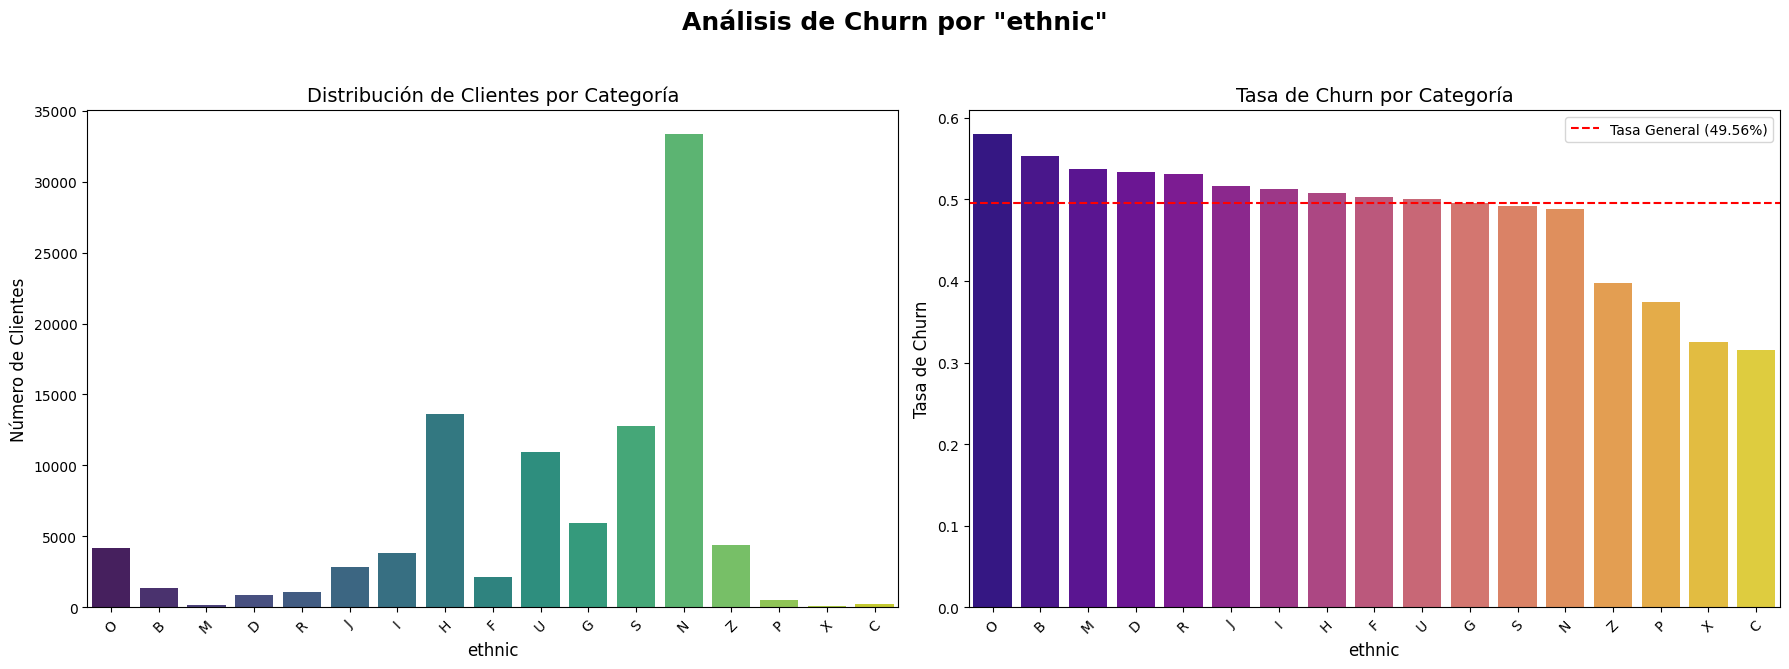

In [75]:
analizar_churn_categorica(df, 'ethnic')

Estos resultados son bastante cruciales. Quiere decir que tenemos un `churn` del 49%, lo cual quiere decir que la mitad de los usuarios se dan de baja (representado por la línea roja en la gráfica de la derecha). El histograma de la izquierda representa 

In [61]:
null_info = calcular_nulos(df)
print(null_info[null_info['Porcentaje']>0])

                  Nulos  Porcentaje
rev_Mean            357       0.357
mou_Mean            357       0.357
totmrc_Mean         357       0.357
da_Mean             357       0.357
ovrmou_Mean         357       0.357
ovrrev_Mean         357       0.357
vceovr_Mean         357       0.357
datovr_Mean         357       0.357
roam_Mean           357       0.357
change_mou          891       0.891
change_rev          891       0.891
prizm_social_one   7388       7.388
area                 40       0.040
dualband              1       0.001
refurb_new            1       0.001
hnd_price           847       0.847
phones                1       0.001
models                1       0.001
hnd_webcap        10189      10.189
ownrent           33706      33.706
lor               30190      30.190
dwlltype          31909      31.909
adults            23019      23.019
infobase          22079      22.079
income            25436      25.436
numbcars          49366      49.366
HHstatin          37923     

## Caso 3: change_mou y change_rev

Como vimos en el caso de las variables `avg6*`, ninguno de los registros está menos de 6 meses en el servicio. Por lo tanto, los nulos de estas variables tampoco están relacionadas con el origen que tienen éstas de ser un cálculo de los 3 meses anteriores.

Sin embargo, estas variables se refieren al "porcentaje de cambio de uso mensual en minutos VS la media de los tres meses anteriores" y "porcentaje de cambio en beneficio mensual VS la media de los tres meses anteriores". En relación a "media de tres meses" tenemos 3 variables: `avg3mou`, `avg3qty` y `avg3rev`, aunque la segunda podemos descartarla, ya que se refiere al número de llamadas, y eso no involucra las variables que estamos estudiando ahora. Nos faltaría tener el beneficio (revenue) mensual y el uso (use) mensual para poder tener la fórmula entera. Resulta que sí que los tenemos: `rev_Mean` (que además, nunca es nulo) y `mou_Mean` (que tampoco es nulo nunca).

Nos faltaría en este caso, el valor de ingresos (rev) y minutos de uso (mou) del último mes para poder calcular `change_rev` y `change_mou`, que es un dato que no tenemos. El dato más aproximado es `rev_Mean`, que es la media del mes, suponemos que calculado en un periodo que no se especifica.

$$
\text{change\_rev} = \frac{\text{rev}_{\text{último mes}} - \text{avg3rev}}{\text{avg3rev}}*100
$$

Por lo tanto, del último mes, tendríamos lo siguiente:

$$
\text{rev}_{\text{último mes}} = (\frac{\text{change\_rev}}{100} * \text{avg3rev})+\text{avg3rev}
$$

Lo que podemos hacer es comprobar cómo de aproximado es este potencial valor del último mes en comparación con `rev_Mean`. Si es lo suficientemente aproximado, podríamos utilizarlo como valor sustitutivo en la fórmula.

In [ ]:
# --- PASO 1: Crear una copia y calcular las columnas necesarias ---
df_analisis = df.dropna(subset=['change_rev', 'change_mou']).copy()

# Calcular el 'Valor_Actual_Calculado'
df_analisis['valor_calculado'] = ((df_analisis['change_rev'] / 100) * df_analisis['avg3rev']) + df_analisis['avg3rev']

# Calcular la diferencia absoluta en euros
df_analisis['diferencia_absoluta'] = (df_analisis['valor_calculado'] - df_analisis['rev_Mean']).abs()

# Calcular la diferencia porcentual
df_analisis['diferencia_porcentaje'] = (df_analisis['diferencia_absoluta'] / df_analisis['rev_Mean'].replace(0, np.nan)) * 100


# --- PASO 2: Comparar las estadísticas de las dos variables principales ---
print("--- Comparación Estadística: rev_Mean vs. Valor_Actual_Calculado ---")
print(df_analisis[['rev_Mean', 'valor_calculado']].describe())


# --- PASO 3: Analizar las estadísticas de la diferencia (el error) ---
print("\n\n--- Análisis Estadístico de la Diferencia (Error de la Aproximación) ---")
print(df_analisis[['diferencia_absoluta', 'diferencia_porcentaje']].describe())


--- Comparación Estadística: rev_Mean vs. Valor_Actual_Calculado ---
           rev_Mean  valor_calculado
count  99109.000000     99109.000000
mean      58.784990        53.735189
std       46.262538       197.376740
min       -6.167500    -16053.298200
25%       33.347500        31.909500
50%       48.295000        44.550000
75%       70.792500        62.619750
max     3843.262500     52532.292150


--- Análisis Estadístico de la Diferencia (Error de la Aproximación) ---
       diferencia_absoluta  diferencia_porcentaje
count         99109.000000           99103.000000
mean             14.226589              12.230198
std             187.940043              99.086581
min               0.000000           -1373.837860
25%               0.225675               0.586083
50%               0.660750               1.843963
75%               5.315900               8.701147
max           48689.029650           17900.000000


Por lo general, esto demuestra que asumir que `rev_Mean` como valor actual del último mes para calcular `change_rev` es una buena aproximación para el usuario promedio. Al final, el error para el 50% de los usuarios está por debajo del 2% en el cálculo de este valor, y para 3 de cada 4, por debajo del 8.7%, que también es aceptable dado que lo queremos para una imputación de valores nulos.

Vamos a hacer el mismo cálculo para `change_mou` en comparación con `mou_Mean`.

In [ ]:
# Calcular el 'Valor_Actual_Calculado'
df_analisis['valor_calculado_mou'] = ((df_analisis['change_mou'] / 100) * df_analisis['avg3mou']) + df_analisis['avg3mou']

# Calcular la diferencia absoluta en euros
df_analisis['diferencia_absoluta_mou'] = (df_analisis['valor_calculado_mou'] - df_analisis['mou_Mean']).abs()

# Calcular la diferencia porcentual
df_analisis['diferencia_porcentaje_mou'] = (df_analisis['diferencia_absoluta_mou'] / df_analisis['mou_Mean'].replace(0, np.nan)) * 100

# --- PASO 2: Comparar las estadísticas de las dos variables principales ---
print("--- Comparación Estadística: mou_Mean vs. Valor_Actual_Calculado ---")
print(df_analisis[['mou_Mean', 'valor_calculado_mou']].describe())


# --- PASO 3: Analizar las estadísticas de la diferencia (el error) ---
print("\n\n--- Análisis Estadístico de la Diferencia (Error de la Aproximación) ---")
print(df_analisis[['diferencia_absoluta_mou', 'diferencia_porcentaje_mou']].describe())

--- Comparación Estadística: mou_Mean vs. Valor_Actual_Calculado ---
           mou_Mean  valor_calculado_mou
count  99109.000000         99109.000000
mean     514.371140           181.073749
std      525.312892          4586.821028
min        0.000000       -195054.250000
25%      151.500000             1.975000
50%      356.500000           128.865000
75%      704.000000           589.850000
max    12206.750000        563746.500000


--- Análisis Estadístico de la Diferencia (Error de la Aproximación) ---
       diferencia_absoluta_mou  diferencia_porcentaje_mou
count             99109.000000               97595.000000
mean               1323.133742                 149.877065
std                4422.654381                 723.983982
min                   0.000000                   0.000000
25%                  34.220000                  21.932642
50%                 227.535000                  68.063011
75%                1011.490000                 171.155227
max              551539

En este caso comprobamos un comportamiento totalmente opuesto. No parece ser una buena asunción que `mou_Mean` sea un equivalente al número de minutos de uso del último mes. Tiene sentido, porque es una variable que puede cambiar mucho de un momento a otro, debido a diferentes circunstancias. En este caso, ya que hablamos de un cambio, vamos a asumir que `change_mou` es 0: si no tenemos información sobre el cambio, asumimos que no existe.

In [ ]:
#Creamos, como siempre, la columna de flag para change_rev y change_mou
crear_flag_nulos(df, 'change_rev', 'change_nan')

#Hacemos la imputación de change_rev aplicando la fórmula de cambio
imputaciones = ((df['rev_Mean'] - df['avg3rev']) / df['avg3rev']) * 100

df['change_rev'] = df['change_rev'].fillna(imputaciones)

len(df[df['change_rev'].isnull()])

Número de 1s en la nueva columna flag: change_nan
1    891
Name: count, dtype: int64



357

Tiene sentido que ahora haya 357 nulos, porque son los nulos ya existenes de `rev_Mean`.

In [ ]:
# Ahora aplicamos la imputación de change_mou, sustituyendo por 0
df['change_mou'] = df['change_mou'].fillna(0)

In [ ]:
null_info = calcular_nulos(df)
print(null_info[null_info['Porcentaje']>0])

                  Nulos  Porcentaje
rev_Mean            357       0.357
mou_Mean            357       0.357
totmrc_Mean         357       0.357
da_Mean             357       0.357
ovrmou_Mean         357       0.357
ovrrev_Mean         357       0.357
vceovr_Mean         357       0.357
datovr_Mean         357       0.357
roam_Mean           357       0.357
change_rev          357       0.357
prizm_social_one   7388       7.388
area                 40       0.040
dualband              1       0.001
refurb_new            1       0.001
hnd_price           847       0.847
phones                1       0.001
models                1       0.001
hnd_webcap        10189      10.189
ownrent           33706      33.706
lor               30190      30.190
dwlltype          31909      31.909
marital            1732       1.732
adults            23019      23.019
infobase          22079      22.079
income            25436      25.436
numbcars          49366      49.366
HHstatin          37923     

In [ ]:

cols_services = ['datovr_Mean', 'ovrrev_Mean', 'vceovr_Mean', 
        'ovrmou_Mean', 'da_Mean', 'mou_Mean', 
        'totmrc_Mean', 'rev_Mean', 'roam_Mean']

for col in cols_services:
    number_zeros = (df[col] == 0).sum()
    print(f"Número de ceros en {col}: {number_zeros}")


Número de ceros en datovr_Mean: 85970
Número de ceros en ovrrev_Mean: 42552
Número de ceros en vceovr_Mean: 47135
Número de ceros en ovrmou_Mean: 42603
Número de ceros en da_Mean: 48411
Número de ceros en mou_Mean: 1615
Número de ceros en totmrc_Mean: 329
Número de ceros en rev_Mean: 12
Número de ceros en roam_Mean: 68650


Ya hay 0s de antes, pero dada la naturaleza de estos datos, sustituir los NaN por 0s tiene sentido, ya que puede reflejar la falta de actividad simultánea de esos servicios.